In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Connect to drive **

# **project title:Cucumber diseases detection**
         **  submitted by**
#           Nayem Mollah
#           2019-1-60-123

           **Submitted to**
#    Mohammad Rifat Ahmmad Rashid

#        Department of CSE



# **Install All Dependences**

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions


from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from PIL import Image as PImage
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import glob
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# **See all the contents**

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE_W = 256
IMAGE_SIZE_H = 256
CHANNELS=3
EPOCHS=10

# **import data into tensorflow dataset object**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/cse475cumcumber/cse475cucumberdataset/Original Image",
    seed=123,
    shuffle=True,
    #color_mode='grayscale',
    image_size=(IMAGE_SIZE_W,IMAGE_SIZE_H),
    batch_size=BATCH_SIZE
)

Found 1289 files belonging to 8 classes.


# Class **name**

In [ ]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'Bacterial Wilt',
 'Belly Rot',
 'Downy Mildew',
 'Fresh Cucumber',
 'Fresh Leaf',
 'Gummy Stem Blight',
 'Pythium Fruit Rot']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 5 5 7 7 2 0 4 3 1 6 2 2 6 7 4 0 3 0 1 6 0 6 3 4 5 4 7 0 7 4 6]


# **visualize some of our image from our dataset**

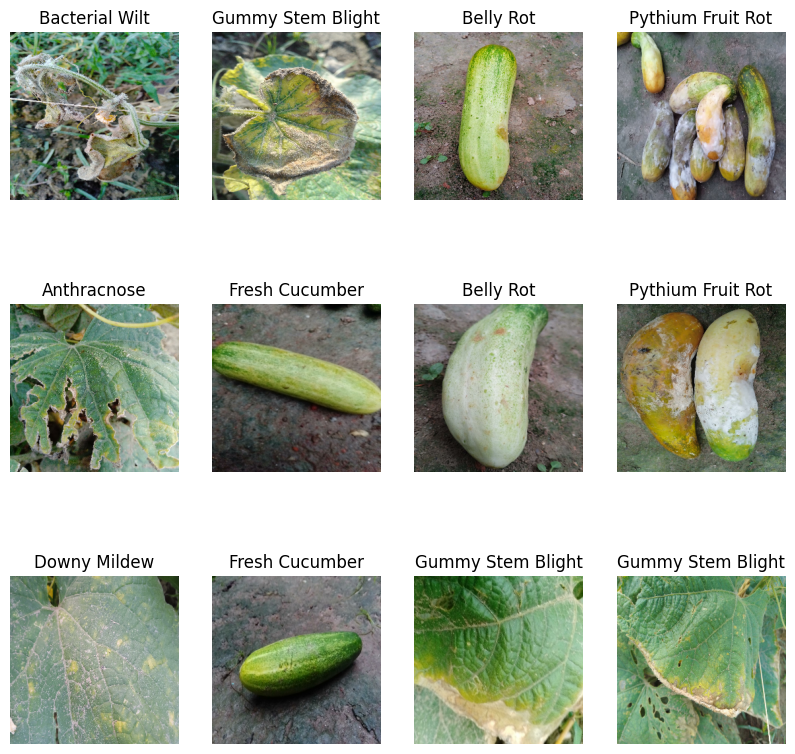

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **function to split dataset**



In [ ]:
len(dataset)

41

In [ ]:
train_size = 0.7
len(dataset)*train_size

28.7

In [ ]:
train_ds = dataset.take(228)
len(train_ds)

41

In [ ]:
test_ds = dataset.skip(200)
len(test_ds)

0

In [ ]:
val_size=0.15
len(dataset)*val_size

6.1499999999999995

In [ ]:
val_ds = test_ds.take(48)
len(val_ds)


0

In [ ]:
test_ds = test_ds.skip(48)
len(test_ds)

0

Train test split

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

32

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

5

# **Shuffle and prefetch dataset**

Shuffling Dataset:

Randomization: Shuffling a dataset randomizes the order of its examples. This is crucial during training because if the dataset is ordered in a specific way (e.g., all samples of one class followed by another), the model might learn patterns related to the order rather than the underlying data distribution. Shuffling ensures that each mini-batch during training contains a random selection of examples.

Improved Generalization: Randomization through shuffling prevents the model from overfitting to specific patterns in the data that might be present due to the ordering. It encourages the model to learn more general and robust features.

Avoiding Sequence Bias: In some cases, like time series data, the order of examples may carry temporal information. However, shuffling can still be useful to avoid introducing biases in the model due to the sequence of examples.

Prefetching Dataset:

Performance Optimization: Prefetching is a technique to overlap data loading and model training. It allows the data loading process to work in parallel with the model training process. As the model is processing one mini-batch of data, the next mini-batch is already being loaded. This reduces the overall time spent waiting for data and can significantly improve training speed, especially on hardware accelerators like GPUs.

Better Resource Utilization: Prefetching helps keep the CPU and GPU busy, as they are both utilized for their respective tasks—data loading and model training—simultaneously. This can result in better resource utilization and more efficient training.


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
 from tensorflow.keras import layers

# **build the model**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  #tf.image.rgb_to_grayscale(input_images)
  #layers.experimental.preprocessing.GaussianNoise(stddev),
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE_W, IMAGE_SIZE_H),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **data augmentation**

Data augmentation is a technique used in machine learning, especially in computer vision tasks
Increased Dataset Size
Improved Generalization
Reducing Overfitting


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 834.5 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Apply data augmentation to train dataset**

Applying data augmentation to the training dataset is a common practice in machine learning, especially in computer vision tasks, for several important reasons:

Increased Diversity: Data augmentation increases the diversity of the training dataset by generating new examples with slight variations from the original data. This diversity exposes the model to a wider range of patterns and features in the data, helping it learn more effectively.

Generalization: By introducing variations and perturbations to the training data, data augmentation helps the model become more robust and generalize better to unseen data. It learns to focus on the essential features of objects rather than memorizing specific instances.

Overfitting Prevention: Data augmentation acts as a form of regularization by making it more challenging for the model to fit the training data perfectly. This reduces the risk of overfitting, where the model memorizes the training data but fails to perform well on new, unseen data


In [102]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds= val_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# **Model Architecture**

 the Sequential model is considered good for its simplicity, ease of use, and efficiency, making it an excellent choice for a wide range of deep learning tasks, especially for those new to the field or those working on projects with relatively straightforward architectures.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE_W, IMAGE_SIZE_H, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 batch_normalization (BatchN  (32, 254, 254, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (32, 125, 125, 32)      

# **Compile the model**

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60)

Epoch 1/60
32/32 [==============================] - 253s 5s/step - loss: 1.5533 - accuracy: 0.4675 - val_loss: 2.2112 - val_accuracy: 0.1016
Epoch 2/60
32/32 [==============================] - 106s 3s/step - loss: 0.9551 - accuracy: 0.6314 - val_loss: 2.4791 - val_accuracy: 0.0938
Epoch 3/60
32/32 [==============================] - 107s 3s/step - loss: 0.7850 - accuracy: 0.7003 - val_loss: 2.6963 - val_accuracy: 0.0938
Epoch 4/60
32/32 [==============================] - 112s 3s/step - loss: 0.6877 - accuracy: 0.7522 - val_loss: 3.0112 - val_accuracy: 0.0938
Epoch 5/60
32/32 [==============================] - 106s 3s/step - loss: 0.6088 - accuracy: 0.7612 - val_loss: 2.9739 - val_accuracy: 0.0938
Epoch 6/60
32/32 [==============================] - 99s 3s/step - loss: 0.5885 - accuracy: 0.7702 - val_loss: 3.4317 - val_accuracy: 0.0938
Epoch 7/60
32/32 [==============================] - 98s 3s/step - loss: 0.5216 - accuracy: 0.8022 - val_loss: 4.3615 - val_accuracy: 0.0938
Epoch 8/60
32/3

# Evaluate the model

In [81]:





scores = model.evaluate(test_ds)


5/5 [==============================] - 4s 925ms/step - loss: 0.6289 - accuracy: 0.8375


In [95]:
scores

[0.6288628578186035, 0.8374999761581421]

# **Plottting the accuracy loss curve**

In [82]:
history

In [83]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 32}

In [78]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [79]:
type(history.history['loss'])

list

In [94]:
len(history.history['loss'])

60

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [99]:
import numpy as np
import matplotlib.pyplot as plt

In [121]:
# Sample data (replace with your actual data)
x = np.random.rand(10)  # Example data for x
y = np.random.rand(60)  # Example data for y

# Plot x
plt.figure(figsize=(8, 4))
##plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.title('acuuracy')
plt.legend()

# Plot y
#plt.subplot(2, 1, 2)
plt.plot(val_acc, label='Validation Accuracy')
plt.title('training and validation accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Loss graph**

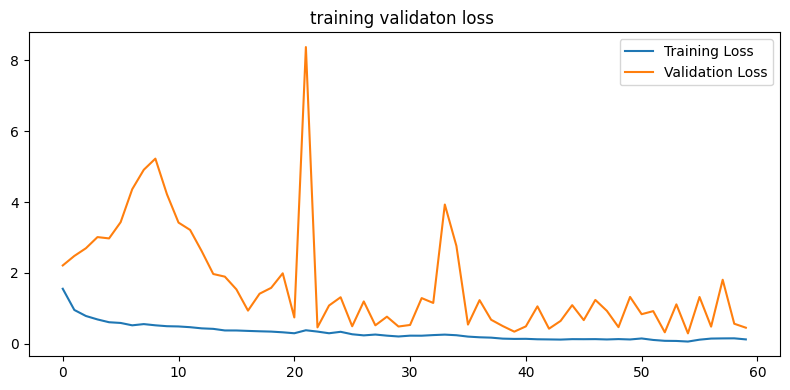

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
x = np.random.rand(10)  # Example data for x
y = np.random.rand(60)  # Example data for y

# Plot x
plt.figure(figsize=(8, 4))
##plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.title('tain loss')
plt.legend()

# Plot y
#plt.subplot(2, 1, 2)
plt.plot(val_loss, label='Validation Loss')
plt.title('training validaton loss ')
plt.legend()

plt.tight_layout()
plt.show()


# **Feature map plot for insightto how actually the feature of our image are extracted**

1/1 [==============================] - 0s 279ms/step
(1, 254, 254, 16)
(1, 254, 254, 16)
(1, 127, 127, 16)
(1, 125, 125, 32)


<ipython-input-49-2a9988033623>:39: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
<ipython-input-49-2a9988033623>:39: RuntimeWarning: divide by zero encountered in divide
  x /= x.std ()


(1, 125, 125, 32)
(1, 62, 62, 32)
(1, 60, 60, 32)
(1, 60, 60, 32)
(1, 30, 30, 32)
(1, 28, 28, 64)
(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 6, 6, 64)
(1, 4, 4, 64)
(1, 4, 4, 64)
(1, 2, 2, 64)
(1, 256)
(1, 64)
(1, 8)


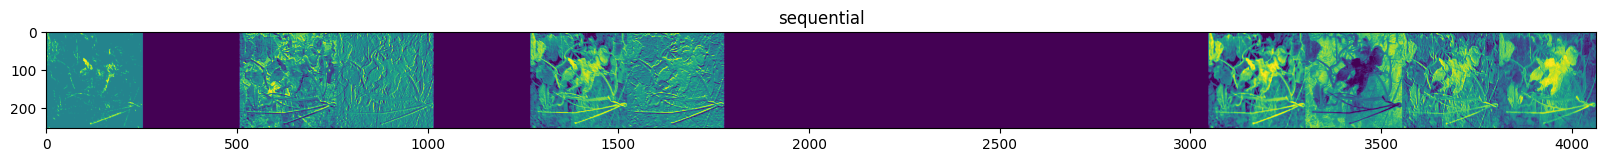

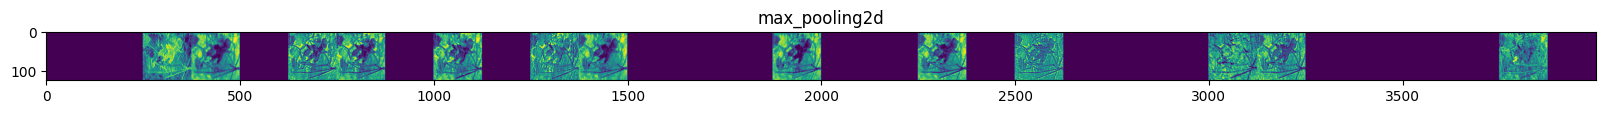

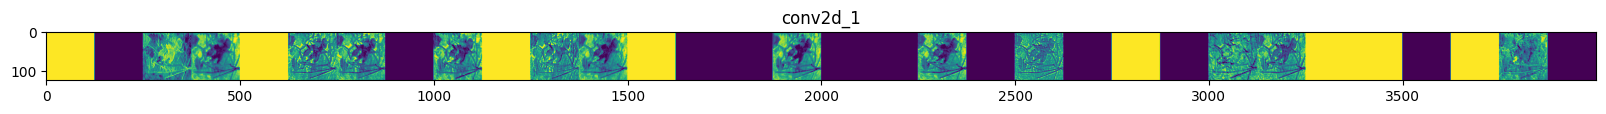

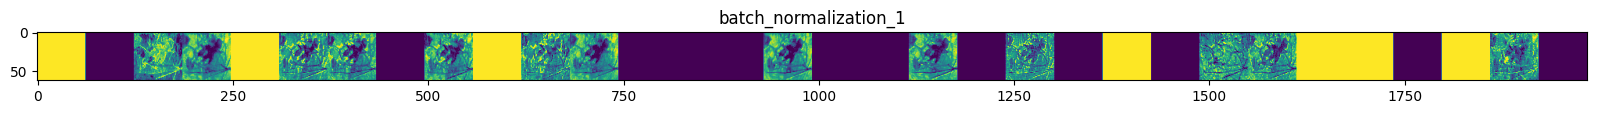

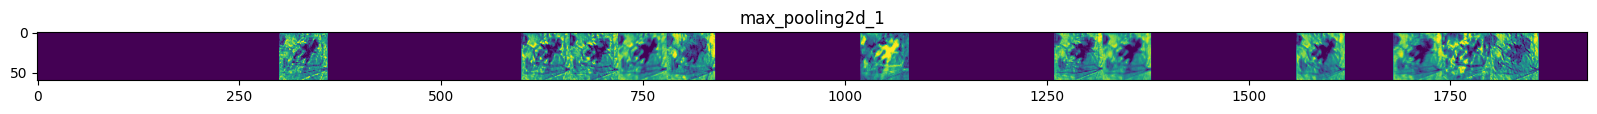

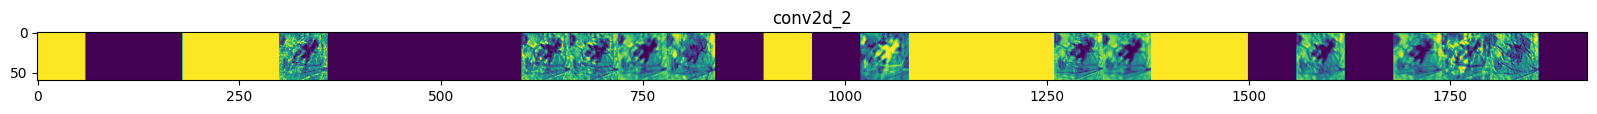

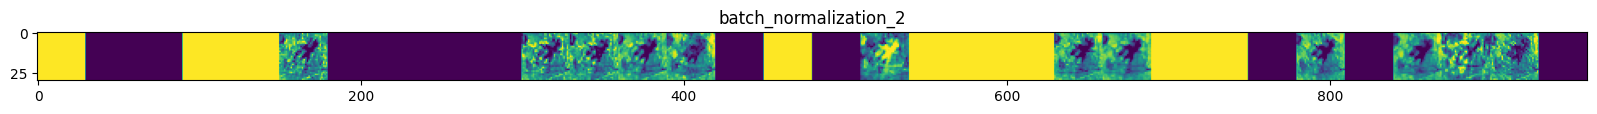

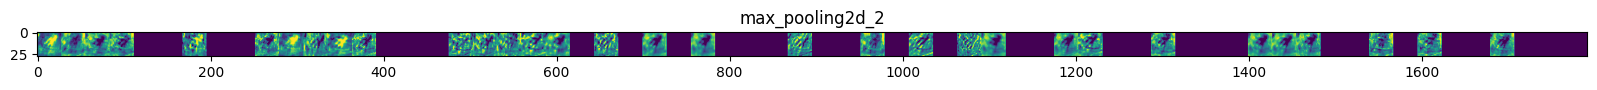

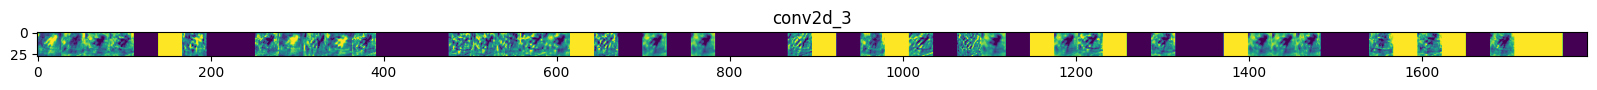

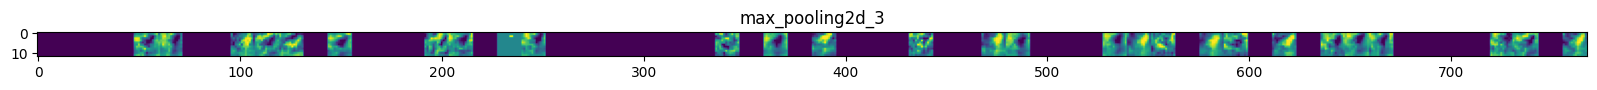

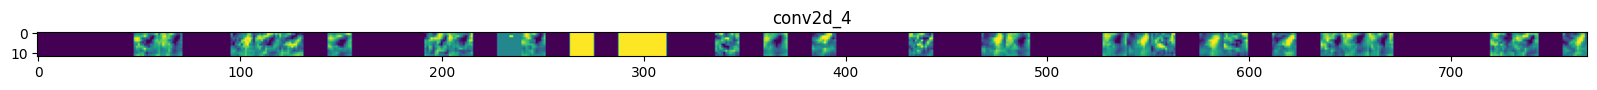

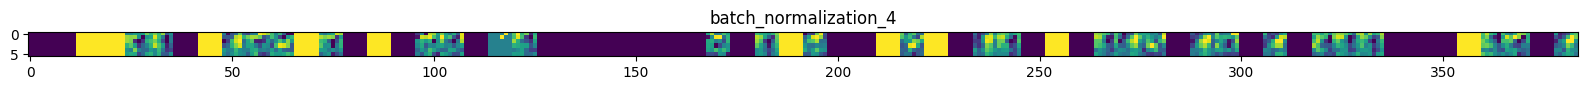

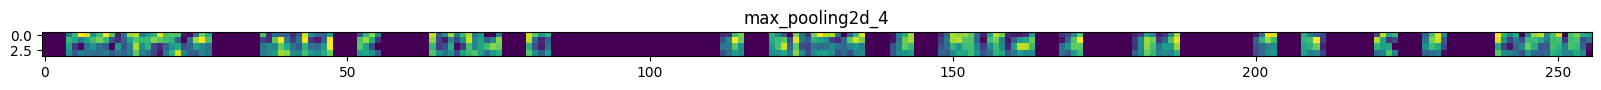

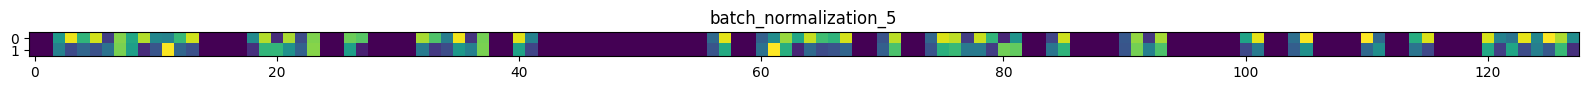

In [49]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np

img_path='/content/drive/MyDrive/cse475cumcumber/cse475cucumberdataset/Original Image/Bacterial Wilt/Bacterial Wilt (1).jpg'
# Define a new Model, Input= image
# Output= intermediate representations for all layers in the
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(256, 256))
x   = img_to_array(img)
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:

    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [50]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 5.5 MB/s eta 0:00:00


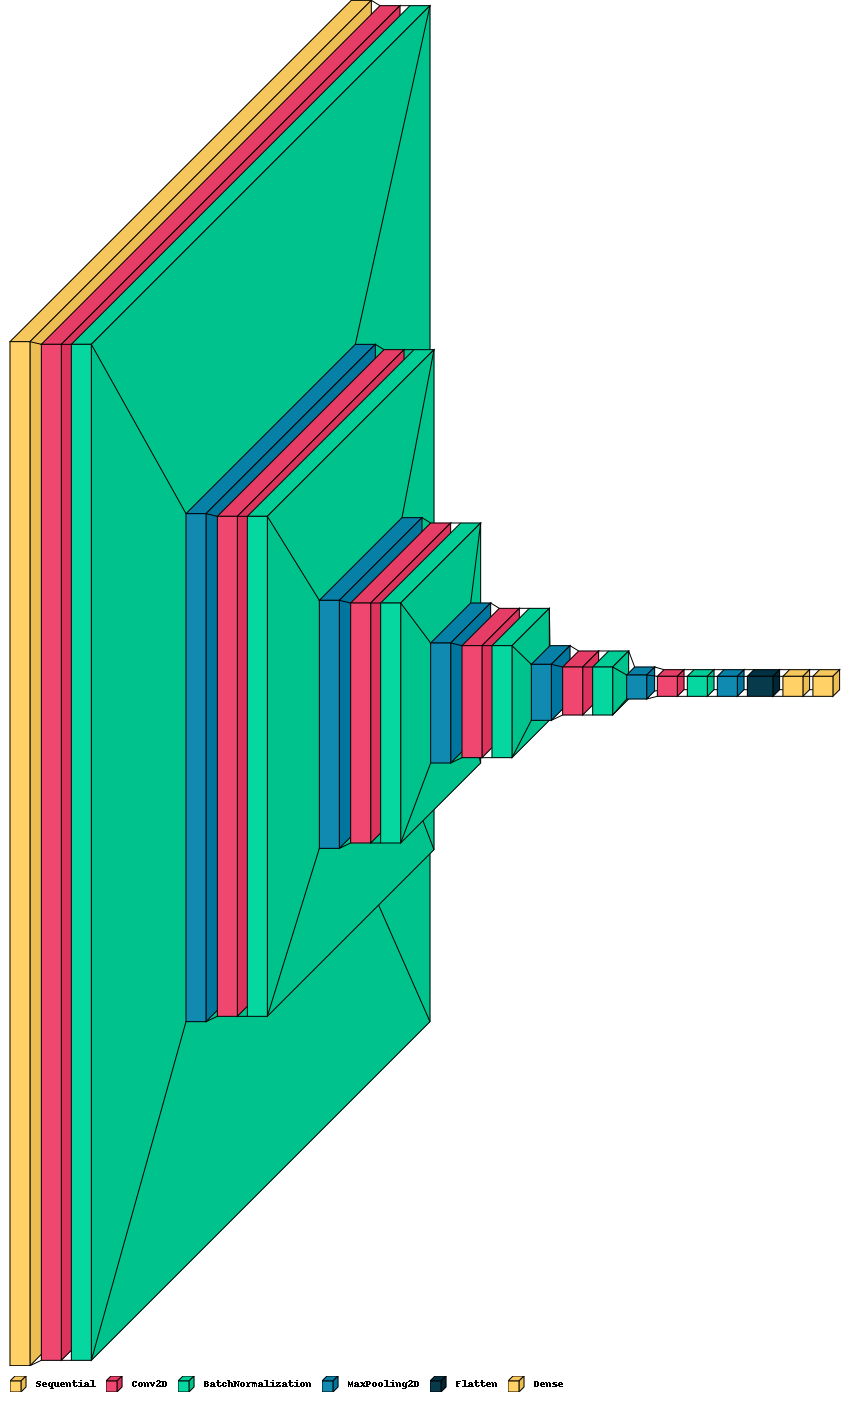

In [51]:
import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict


visualkeras.layered_view(model).show()
visualkeras.layered_view(model, to_file='output.png')
visualkeras.layered_view(model, to_file='output.png').show()

from PIL import ImageFont

#font = ImageFont.truetype("C:\Windows\Fonts\Arial",32 )  # using comic sans is strictly prohibited!

model.add(visualkeras.SpacingDummyLayer(spacing=100))
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, color_map=color_map, legend=True,spacing=10)

In [52]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# **Run prediction on simple image**

first image to predict
actual label: Bacterial Wilt
1/1 [==============================] - 2s 2s/step
predicted label: Bacterial Wilt


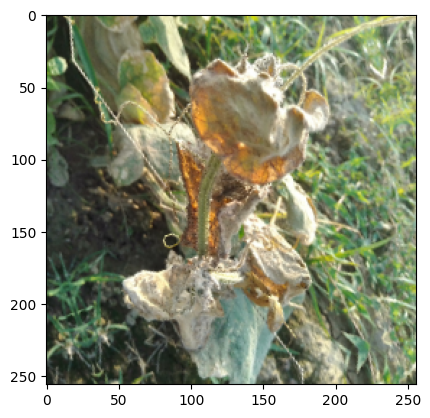

In [53]:
import numpy as np
for images_batch, labels_batch in train_ds.take(1):


    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# **Write a function for interface**

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


# **Now run interface on few sample imag**e

1/1 [==============================] - 0s 48ms/step


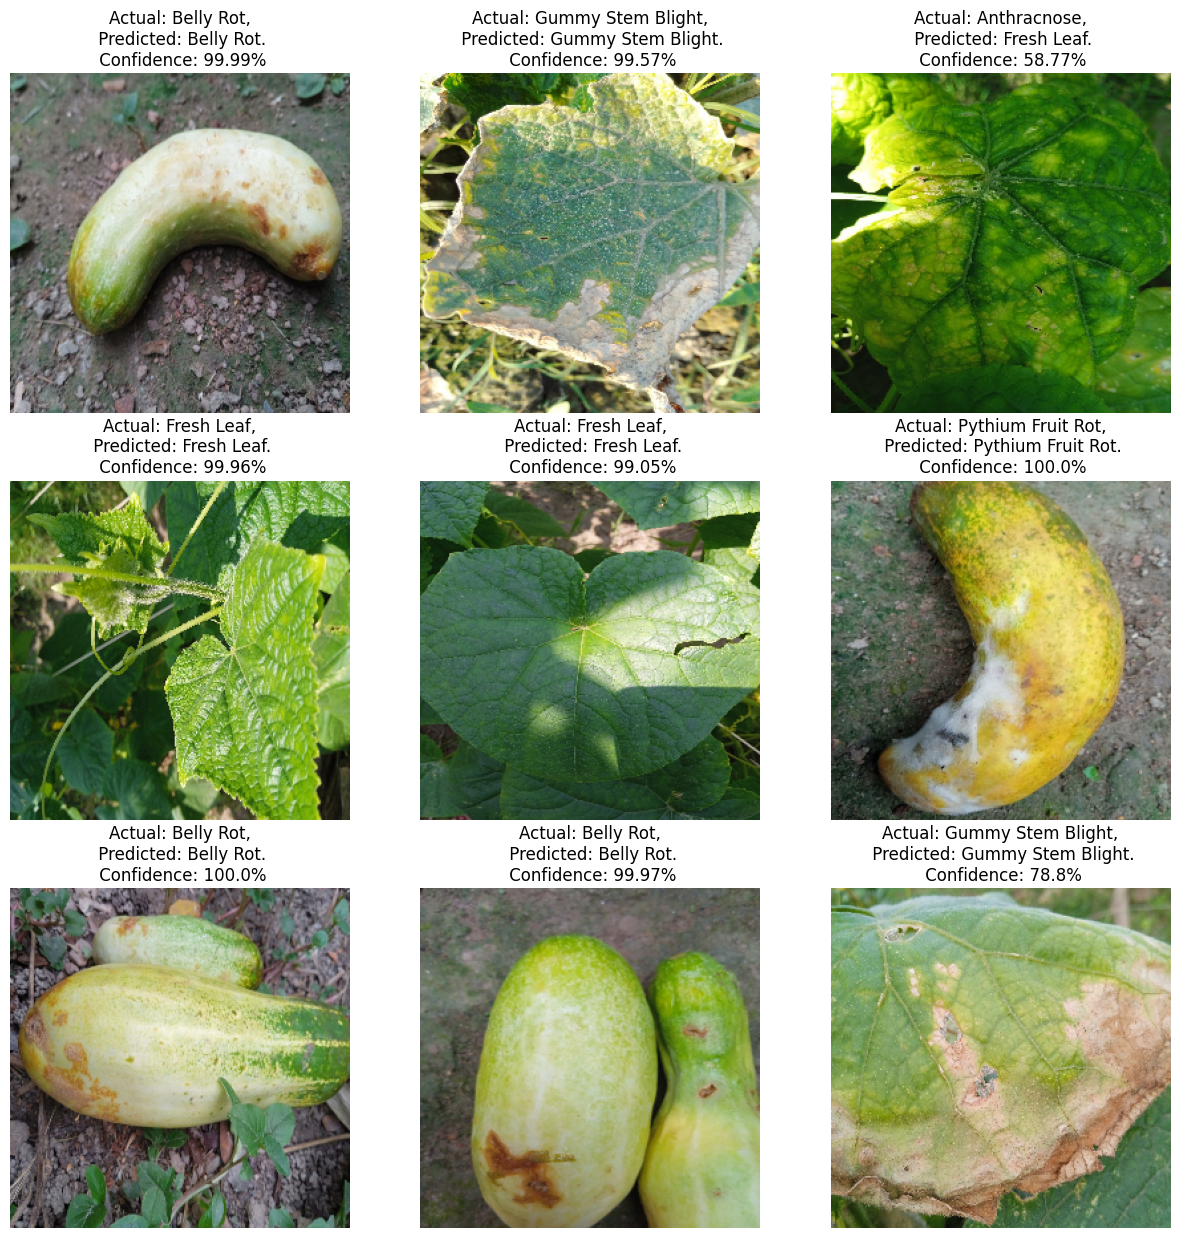

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


## **show precision recall and F1 value**

In [56]:
!pip install scikit-learn


In [57]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


In [58]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store actual and predicted labels for the batch
actual_labels = []
predicted_labels = []

for images_batch, labels_batch in train_ds.take(1):
    for i in range(len(images_batch)):
        image = images_batch[i].numpy()
        label = labels_batch[i].numpy()

        actual_labels.append(label)

        # Make predictions for the current image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Expand dimensions to make it a batch of 1
        predicted_label = np.argmax(prediction[0])  # Assuming it's a classification task

        predicted_labels.append(predicted_label)

# Convert lists to numpy arrays for easier calculation
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(actual_labels, predicted_labels, average='macro')
recall = recall_score(actual_labels, predicted_labels, average='macro')
f1 = f1_score(actual_labels, predicted_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


1/1 [==============================] - 0s 116ms/step
Precision: 0.8928571428571429
Recall: 0.8809523809523808
F1 Score: 0.8826530612244898


# **Confusion matrix**

In [123]:
import numpy as np
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(actual_labels, predicted_labels)



# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[ 2  0  0  0  0  1  0]
 [ 0 11  0  0  0  0  0]
 [ 1  0  3  0  0  0  0]
 [ 0  0  0  3  0  0  0]
 [ 0  0  0  0  3  0  0]
 [ 1  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  4]]


# **conclusion**
my train accuracy is 95%
and my test accuracy is 83%
it predict successfully
